In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import ast

# === 1. Load trajectory audit data ===
audit_path = "data/generated/eval_output_dqn_real.csv"
df = pd.read_csv(audit_path)

# === 2. Check if reward_components exists ===
if "reward_components" not in df.columns:
    print("⚠️ No reward components found. Make sure your env returns them correctly.")
    exit()

# === 3. Preprocess reward_components string to clean np.float64 calls ===
def clean_np_float64(s):
    if isinstance(s, str):
        # Replace np.float64(123.0) -> 123.0
        return re.sub(r'np\.float64\((.*?)\)', r'\1', s)
    return s

df["reward_components"] = df["reward_components"].apply(clean_np_float64)

# === 4. Convert string to dict safely ===
df["reward_components"] = df["reward_components"].apply(ast.literal_eval)

# === 5. Flatten reward_components into separate columns ===
df_components = pd.json_normalize(df["reward_components"])
df = pd.concat([df, df_components], axis=1)
reward_components = list(df_components.columns)

# === 6. Summary Table ===
avg_contributions = df[reward_components].mean().sort_values(ascending=False)
sum_contributions = df[reward_components].sum().sort_values(ascending=False)

summary_df = pd.DataFrame({
    "mean_contribution": avg_contributions,
    "total_contribution": sum_contributions
})

os.makedirs("analysis/LAST_PUSH", exist_ok=True)
summary_df.to_csv("analysis/LAST_PUSH/reward_component_summary.csv")
print("✅ Saved reward component summary table to analysis/LAST_PUSH/reward_component_summary.csv")



✅ Saved reward component summary table to analysis/LAST_PUSH/reward_component_summary.csv


In [5]:
# === 7. Viso indėlio stulpelinė diagrama ===
plt.figure(figsize=(12, 6))
sum_contributions.plot(kind="barh")
plt.title("🔍 Atlygio komponentų bendras indėlis")
plt.xlabel("Bendras indėlis į atlygį")
plt.tight_layout()
plt.savefig("analysis/LAST_PUSH/reward_component_totals.png")
plt.close()
print("✅ Išsaugota: Bendras komponentų indėlio grafikas (reward_component_totals.png)")

# === 8. Koreliacija su galutiniu atlygiu ===
if "reward" in df.columns:
    plt.figure(figsize=(10, 6))
    corr = df[reward_components + ["reward"]].corr()["reward"].drop("reward").sort_values()
    sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
    plt.title("Atlygio komponentų koreliacija su galutiniu atlygiu")
    plt.xlabel("Koreliacija su bendra atlygio verte")
    plt.tight_layout()
    plt.savefig("analysis/LAST_PUSH/reward_component_vs_total_correlation.png")
    plt.close()
    print("✅ Išsaugota: Komponentų koreliacijos grafikas (reward_component_vs_total_correlation.png)")

# === 9. SHAP tipo globali komponentų svarba ===
plt.figure(figsize=(10, 6))
shap_like_importance = df[reward_components].abs().mean().sort_values(ascending=True)
sns.barplot(x=shap_like_importance.values, y=shap_like_importance.index, palette="viridis")
plt.title("Komponenčių globali svarba (vidutinė absoliuti reikšmė)")
plt.xlabel("Vidutinė absoliuti įtaka atlygiui")
plt.ylabel("Atlygio komponentas")
plt.tight_layout()
plt.savefig("analysis/LAST_PUSH/shap_like_global_importance.png")
plt.close()
print("✅ Išsaugota: SHAP tipo komponentų svarbos grafikas (shap_like_global_importance.png)")

/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_77563/2154073042.py:6: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_77563/2154073042.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.savefig("analysis/LAST_PUSH/reward_component_totals.png")
/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_77563/2154073042.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_77563/2154073042.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=Fal

✅ Išsaugota: Bendras komponentų indėlio grafikas (reward_component_totals.png)
✅ Išsaugota: Komponentų koreliacijos grafikas (reward_component_vs_total_correlation.png)
✅ Išsaugota: SHAP tipo komponentų svarbos grafikas (shap_like_global_importance.png)


/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_77563/2804343389.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_like_importance.values, y=shap_like_importance.index, palette="viridis", ax=axes[0])
/var/folders/sh/y7_11shj52j5ym8tns5r5r0h0000gn/T/ipykernel_77563/2804343389.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="coolwarm", ax=axes[1])


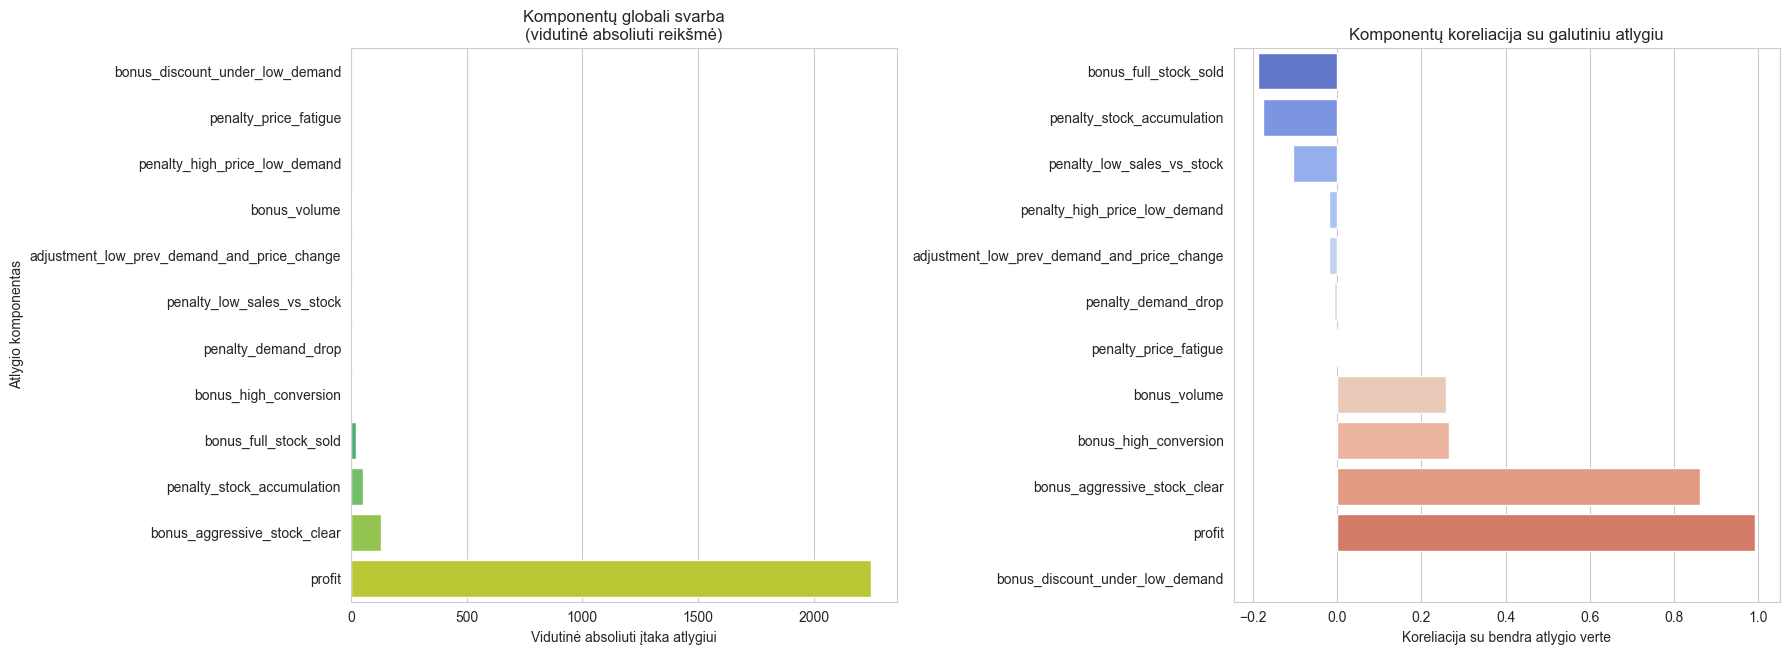

✅ Išsaugota: SHAP ir koreliacijos kombinacija (reward_components_shap_corr_matrix.png)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Kombinuota matrica: SHAP tipo svarba + Koreliacija ===
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1. SHAP tipo globali komponentų svarba
shap_like_importance = df[reward_components].abs().mean().sort_values(ascending=True)
sns.barplot(x=shap_like_importance.values, y=shap_like_importance.index, palette="viridis", ax=axes[0])
axes[0].set_title("Komponentų globali svarba\n(vidutinė absoliuti reikšmė)", fontsize=12)
axes[0].set_xlabel("Vidutinė absoliuti įtaka atlygiui")
axes[0].set_ylabel("Atlygio komponentas")

# 2. Koreliacija su galutiniu atlygiu
if "reward" in df.columns:
    corr = df[reward_components + ["reward"]].corr()["reward"].drop("reward").sort_values()
    sns.barplot(x=corr.values, y=corr.index, palette="coolwarm", ax=axes[1])
    axes[1].set_title("Komponentų koreliacija su galutiniu atlygiu", fontsize=12)
    axes[1].set_xlabel("Koreliacija su bendra atlygio verte")
    axes[1].set_ylabel("")

#plt.suptitle("SHAP ir koreliacijos analizė", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("analysis/LAST_PUSH/reward_components_shap_corr_matrix.png")
plt.show()

print("✅ Išsaugota: SHAP ir koreliacijos kombinacija (reward_components_shap_corr_matrix.png)")

/Users/zydrunasbautronis/Documents/KTU/Baigiamasis_darbas/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/zydrunasbautronis/Documents/KTU/Baigiamasis_darbas/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zydrunasbautronis/Documents/KTU/Baigiamasis_darbas/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



=== Normalumo testų lentelė ===
                                    feature      W  p_value  normal?
                                     profit 0.3490      0.0    False
                      bonus_full_stock_sold 0.6303      0.0    False
                 penalty_stock_accumulation 0.7774      0.0    False
                      bonus_high_conversion 0.5820      0.0    False
                 penalty_low_sales_vs_stock 0.5493      0.0    False
                               bonus_volume 0.9113      0.0    False
                        penalty_demand_drop 0.6029      0.0    False
              penalty_high_price_low_demand 0.4866      0.0    False
            bonus_discount_under_low_demand 1.0000      1.0     True
adjustment_low_prev_demand_and_price_change 0.7471      0.0    False
                      penalty_price_fatigue 0.1781      0.0    False
               bonus_aggressive_stock_clear 0.0871      0.0    False

⚠️ Įdiekite 'factor_analyzer', jei norite Bartlett & KMO testų.

=== 

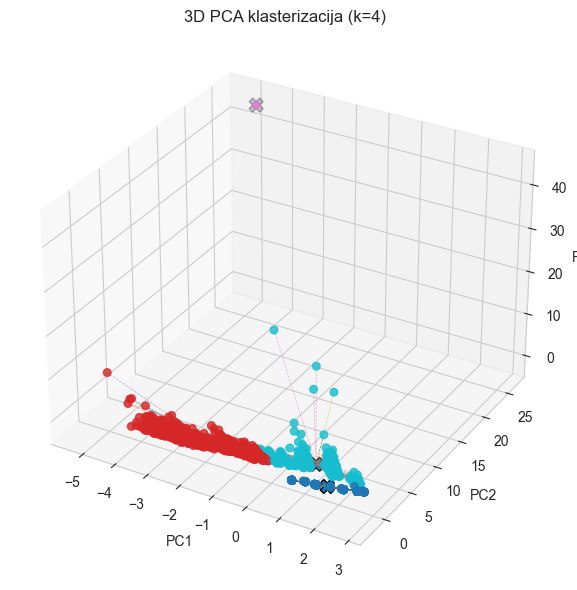

In [9]:
import pandas as pd
import numpy as np
import re
import ast
from scipy.stats import shapiro, spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Optional: Bartlett & KMO
try:
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
    fa_available = True
except ImportError:
    fa_available = False

# 1. Load data
audit_path = "data/generated/eval_output_dqn_real.csv"  # pataisykite kelią
df = pd.read_csv(audit_path)

# 2. Expand reward_components
def clean_np64(s):
    if isinstance(s, str):
        return re.sub(r'np\.float64\((.*?)\)', r'\1', s)
    return s

df["reward_components"] = df["reward_components"].apply(clean_np64).apply(ast.literal_eval)
dfc = pd.json_normalize(df["reward_components"])
features = dfc.columns.tolist()

# 3. Normalumo testai
norm_results = []
for f in features:
    W, p = shapiro(dfc[f].dropna())
    norm_results.append({"feature": f, "W": W, "p_value": p})
norm_df = pd.DataFrame(norm_results)
norm_df["normal?"] = norm_df["p_value"] > 0.05
# decide
use_spearman = not norm_df["normal?"].all()

print("\n=== Normalumo testų lentelė ===")
print(norm_df.round(4).to_string(index=False))

# 4. Bartlett & KMO (jei įdiegta)
if fa_available:
    chi2, bart_p = calculate_bartlett_sphericity(dfc)
    _, kmo_model = calculate_kmo(dfc)
    print(f"\nBartlett’o testas: chi2={chi2:.2f}, p={bart_p:.4f}")
    print(f"KMO: {kmo_model:.4f}")
else:
    print("\n⚠️ Įdiekite 'factor_analyzer', jei norite Bartlett & KMO testų.")

# 5. Koreliacijų matrica
method = "Spearman" if use_spearman else "Pearson"
if use_spearman:
    corr_mat, _ = spearmanr(dfc)
    corr = pd.DataFrame(corr_mat, index=features, columns=features)
else:
    corr = dfc.corr(method='pearson')
print(f"\n=== {method} koreliacijų matrica ===")
print(corr.round(3))

# 6. Elbow metodas: SSD kiekvienam k
ssd = []
ks = list(range(1, 11))
X = StandardScaler().fit_transform(dfc)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    ssd.append(km.inertia_)
elbow_df = pd.DataFrame({"k": ks, "SSD": ssd})
print("\n=== Elbow metodo lentelė ===")
print(elbow_df.to_string(index=False))

# Pasirinkite k pagal “alkūnę”:
chosen_k = 4  # <— pasikeiskite į tą, kurį nusprendėte

# 7. PCA + klasterizacija + 3D grafikas
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)
kmeans = KMeans(n_clusters=chosen_k, random_state=42).fit(pcs)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=labels, cmap='tab10', s=30, alpha=0.8)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], marker='X', s=100, edgecolor='k')
for i, pt in enumerate(pcs):
    c = centers[labels[i]]
    ax.plot([pt[0],c[0]],[pt[1],c[1]],[pt[2],c[2]], linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.set_title(f'3D PCA klasterizacija (k={chosen_k})')
plt.tight_layout()
plt.show()

=== PCA komponentų svoriai (loadings) ===
                                               PC1    PC2    PC3
profit                                      -0.194  0.324  0.588
bonus_full_stock_sold                        0.445 -0.129  0.183
penalty_stock_accumulation                   0.489  0.064  0.038
bonus_high_conversion                       -0.365  0.377 -0.252
penalty_low_sales_vs_stock                   0.428  0.107  0.025
bonus_volume                                -0.128  0.504 -0.232
penalty_demand_drop                          0.318  0.369 -0.147
penalty_high_price_low_demand                0.250  0.253 -0.133
bonus_discount_under_low_demand              0.000  0.000  0.000
adjustment_low_prev_demand_and_price_change  0.168  0.377 -0.248
penalty_price_fatigue                        0.016 -0.023  0.029
bonus_aggressive_stock_clear                 0.005  0.352  0.632


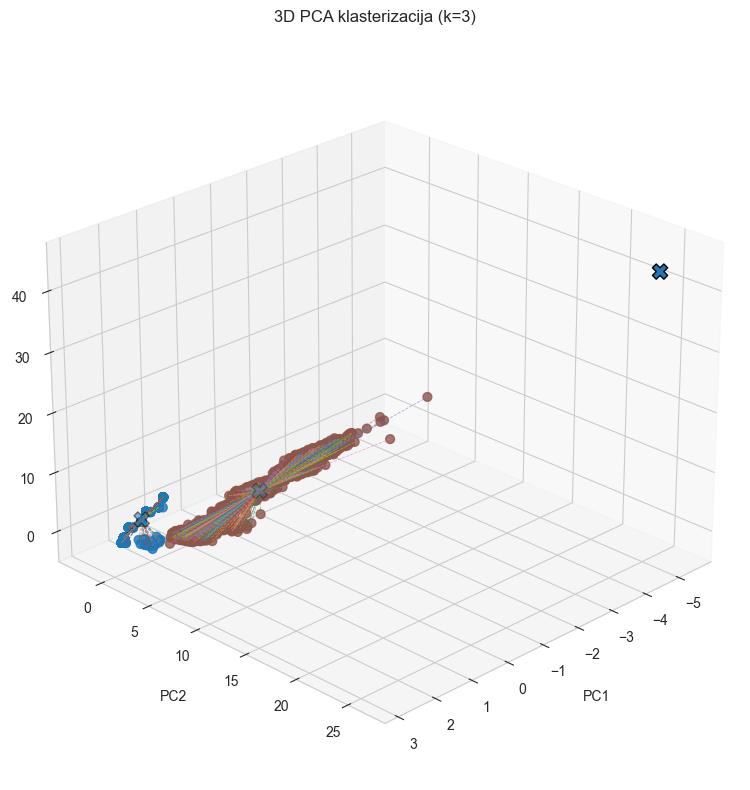

In [20]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Įkeliam ir išplečiam reward_components
df = pd.read_csv("data/generated/eval_output_dqn_real.csv")
def clean_np64(s):
    return re.sub(r'np\.float64\((.*?)\)', r'\1', s) if isinstance(s, str) else s
df["reward_components"] = df["reward_components"]\
    .apply(clean_np64)\
    .apply(ast.literal_eval)
dfc = pd.json_normalize(df["reward_components"])
features = dfc.columns.tolist()

# 2. Standartizuojam ir darom PCA (3 komponentams)
X = StandardScaler().fit_transform(dfc)
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)

# 3. Išvedam PCA loadings – kiekvienos pradinės savybės svorį PC1–PC3
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=['PC1','PC2','PC3']
).round(3)
print("=== PCA komponentų svoriai (loadings) ===")
print(loadings.to_string())

# 4. Toliau – klasterizacija ir 3D grafikas (pvz. k=3)
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(pcs)
labels = km.labels_
centers = km.cluster_centers_

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=labels, cmap='tab10', s=40, alpha=0.8)
ax.scatter(centers[:,0], centers[:,1], centers[:,2], marker='X', s=120, edgecolor='k')
for i, pt in enumerate(pcs):
    c = centers[labels[i]]
    ax.plot([pt[0], c[0]], [pt[1], c[1]], [pt[2], c[2]],
            linestyle='--', linewidth=0.6, alpha=0.6)
ax.set_xlabel('PC1', labelpad=12)
ax.set_ylabel('PC2', labelpad=12)
ax.set_zlabel('PC3', labelpad=16)
ax.view_init(elev=25, azim=45)
ax.set_title(f'3D PCA klasterizacija (k={k})', pad=20)
# Fiksuojame PC3 etiketės sukimą (neleidžiame diagramai jį „pasukti“ automatiškai)
ax.zaxis.set_rotate_label(False)
# Nustatome etiketės kampą ir atstumą nuo ašies
ax.set_zlabel('PC3', rotation=90, labelpad=20, fontsize=12)

# Jeigu reikia – galite dar truputį pakoreguoti view angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

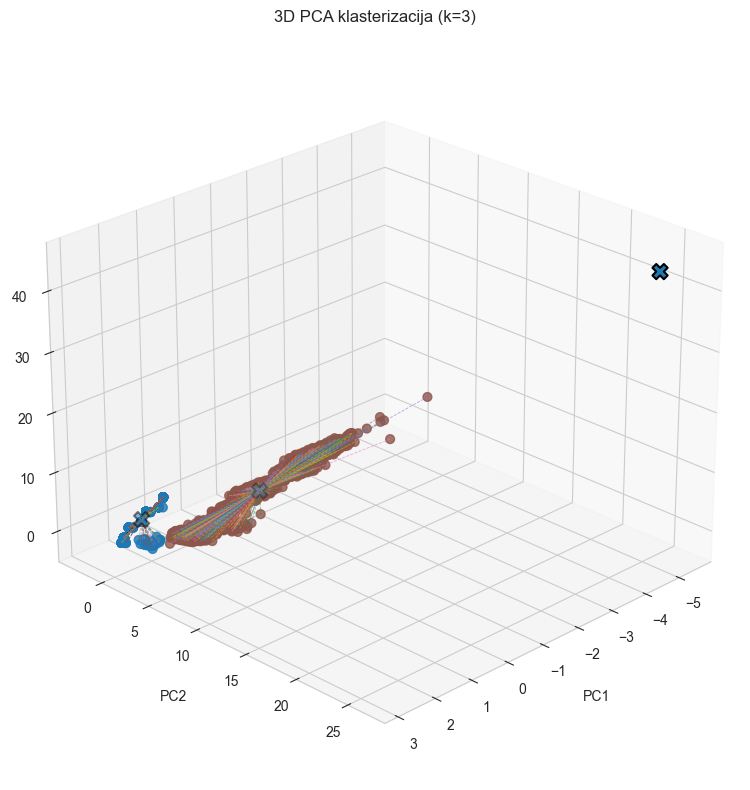

In [18]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Įkeliam ir išplečiam reward_components
df = pd.read_csv("data/generated/eval_output_dqn_real.csv")
def clean_np64(s):
    return re.sub(r'np\.float64\((.*?)\)', r'\1', s) if isinstance(s, str) else s
df["reward_components"] = df["reward_components"]\
    .apply(clean_np64)\
    .apply(ast.literal_eval)
dfc = pd.json_normalize(df["reward_components"])
features = dfc.columns.tolist()

# 2. Standartizuoja ir daro PCA
X = StandardScaler().fit_transform(dfc)
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)

# 3. Klasterizacija (k=3 pagal Elbow)
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(pcs)
labels = km.labels_
centers = km.cluster_centers_

# 4. 3D grafikas su tinkama peržiūra
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Sklaidos taškai
ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2],
           c=labels, cmap='tab10', s=40, alpha=0.8)

# Klasterių centrai
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           marker='X', s=120, edgecolor='k', linewidth=1.5)

# Jungiančios linijos
for i, pt in enumerate(pcs):
    c = centers[labels[i]]
    ax.plot([pt[0], c[0]], [pt[1], c[1]], [pt[2], c[2]],
            linestyle='--', linewidth=0.6, alpha=0.6)

# Ašių pavadinimai su labelpad, kad PC3 matytųsi aiškiai
ax.set_xlabel('PC1', labelpad=12)
ax.set_ylabel('PC2', labelpad=12)
ax.set_zlabel('PC3', labelpad=16)

# Geresnis kampas, kad matytųsi PC3 ašis
ax.view_init(elev=25, azim=45)

ax.set_title(f'3D PCA klasterizacija (k={k})', pad=20)
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Įkelkite ir išplėskite reward_components
df = pd.read_csv("data/generated/eval_output_dqn_real.csv")
def clean_np64(s):
    return re.sub(r'np\.float64\((.*?)\)', r'\1', s) if isinstance(s, str) else s
df["reward_components"] = df["reward_components"]\
    .apply(clean_np64)\
    .apply(ast.literal_eval)
dfc = pd.json_normalize(df["reward_components"])

# 2. Standartizuokite ir atlikite PCA (3 komponenčių nereikia naudoti vėliau)
X = StandardScaler().fit_transform(dfc)
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)

# 3. Klasterizacija (pvz. k=3 pagal Elbow)
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(pcs)
df["cluster"] = km.labels_

# 4. Pridėkite kategorijas
# Tarkime df turi stulpelius 'category' ir 'product_category_name'
cluster_info = df.groupby(["cluster", "category"])\
                 .agg(product_categories=("product_category_name", lambda names: sorted(set(names))))\
                 .reset_index()

# 5. Išspausdinkite kiekvieno klasterio pagrindines kategorijas ir jų subkategorijas
for cl in sorted(cluster_info["cluster"].unique()):
    sub = cluster_info[cluster_info["cluster"] == cl]
    print(f"\n=== Klasteris {cl} ===")
    for _, row in sub.iterrows():
        cat = row["category"]
        subcats = row["product_categories"]
        print(f"• {cat}: {', '.join(subcats)}")


=== Klasteris 0 ===
• agro_industry_commerce: agro_industry_commerce
• arts: arts
• automotive: automotive
• baby_products: baby_products
• beauty_health: beauty_health
• bed_bath: bed_bath
• books_general: books_general
• christmas_items: christmas_items
• climate_control: climate_control
• cool_stuff: cool_stuff
• diapers_hygiene: diapers_hygiene
• drinks: drinks
• electronics: electronics
• electronics_accessories: electronics_accessories
• fashion_shoes: fashion_shoes
• flowers: flowers
• food: food
• furniture_decor: furniture_decor
• home_appliances: home_appliances
• home_construction: home_construction
• home_utilities: home_utilities
• industry_business: industry_business
• insurance_services: insurance_services
• kids_clothing: kids_clothing
• kitchen: kitchen
• market_place: market_place
• men_clothing: men_clothing
• music_cds_dvds: music_cds_dvds
• musical_instruments: musical_instruments
• office_furniture: office_furniture
• party_supplies: party_supplies
• perfumery: p

In [13]:
import pandas as pd
import numpy as np
import re
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Įkelkite ir išplėskite reward_components
df = pd.read_csv("data/generated/eval_output_dqn_real.csv")
def clean_np64(s):
    return re.sub(r'np\.float64\((.*?)\)', r'\1', s) if isinstance(s, str) else s
df["reward_components"] = df["reward_components"]\
    .apply(clean_np64)\
    .apply(ast.literal_eval)
dfc = pd.json_normalize(df["reward_components"])

# 2. Standartizuokite ir PCA (3 komponentai, kad būtų įvestis klasterizacijai)
X = StandardScaler().fit_transform(dfc)
pca = PCA(n_components=3)
pcs = pca.fit_transform(X)

# 3. Klasterizacija (k=3 pagal Elbow)
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(pcs)
df["cluster"] = km.labels_

# 4. Pagrindinių kategorijų pasiskirstymas per klasterius
#   – absoliutūs skaičiai
count_df = (
    df
    .groupby(["cluster", "category"])
    .size()
    .reset_index(name="count")
    .sort_values(["cluster", "count"], ascending=[True, False])
)
print("=== Category counts per cluster ===")
print(count_df.to_string(index=False))

#   – santykinės proporcijos (pro centus kiekviename klasteryje)
prop_df = (
    count_df
    .assign(prop=lambda d: d["count"] / d.groupby("cluster")["count"].transform("sum") * 100)
)
print("\n=== Category proportions per cluster (%) ===")
print(prop_df.round({"prop":1}).to_string(index=False))

# 5. (Papildomai) galite pivotuoti, kad būtų aiški matrica:
pivot_counts = count_df.pivot(index="cluster", columns="category", values="count").fillna(0).astype(int)
pivot_props  = prop_df.pivot(index="cluster", columns="category", values="prop").fillna(0).round(1)

print("\n=== Pivot table: counts ===")
print(pivot_counts)
print("\n=== Pivot table: % proportions ===")
print(pivot_props)

=== Category counts per cluster ===
 cluster                 category  count
       0          diapers_hygiene     50
       0       insurance_services     50
       0                  flowers     48
       0            kids_clothing     47
       0                  kitchen     44
       0           party_supplies     44
       0           music_cds_dvds     43
       0           tools_security     37
       0          christmas_items     36
       0        industry_business     32
       0           women_clothing     31
       0                     arts     30
       0                   drinks     30
       0   agro_industry_commerce     25
       0        home_construction     22
       0                     food     13
       0          home_appliances     13
       0             men_clothing     11
       0          climate_control     10
       0            fashion_shoes      9
       0            books_general      8
       0      musical_instruments      8
       0             